In [50]:
import numpy as np
import math, time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import model_selection
from scipy.spatial import distance
from skimage.measure import compare_ssim

np.random.seed(348)
show = False
show_test = False
fn_train = 'dataTrain.bin'
fn_train_labels = 'labelsTrain.bin'
fn_test = 'dataTest.bin'
fn_test_labels = 'labelsTest.bin'
n_train = 50 # Число рисунков для обучения
n_test = 100 # Число тестовых рисунков
clr_mim, clr_max = 75, 255 # Диапазон оттенков серого цвета
w, h = 64, 64 # Ширина и высота рисунка
w2 = w / 2
h2 = h/2
border = 1 # Граница
#

In [35]:
def plot_data(data, ttl, cls):
    plt.figure(ttl)
    k = 0
    for i in range(30):
        j = np.random.randint(data.shape[0])
        k += 1
        plt.subplot(3, 10, k)
        plt.imshow(data[i], cmap = 'gray')
        plt.title(cls, fontsize = 11)
        plt.axis('off')
    plt.subplots_adjust(hspace = -0.1) # wspace
    plt.show()
def load_data(fn, fn2):
    with open(fn, 'rb') as read_binary:
        data = np.fromfile(read_binary, dtype = np.uint8)
    with open(fn2, 'rb') as read_binary:
        labels = np.fromfile(read_binary, dtype = np.uint8)
    return data, labels

In [4]:
def img_smty(data, min_dssi):
        sim_img = []
        for i in range(data.shape[0]):
            img1 = data[i]
            for j in range(i+1, data.shape[0]):
                img2 = data[j]
                if ((1 - compare_ssim(img1 , img2)) / 2) < min_dssi:
                    sim_img.append([i, j])
        return np.array(sim_img)
    
def two_img_smty(data1, data2, min_dssi):
        sim_img = []
        for i in range(data1.shape[0]):
            img1 = data1[i]
            for j in range(i+1, data2.shape[0]):
                img2 = data2[j]
                if ((1 - compare_ssim(img1 , img2)) / 2) < min_dssi:
                    sim_img.append([i, j])
        return np.array(sim_img)
def min_sim(data, n):
    res = (1 - compare_ssim(data[0] , data[1])) / 2
    for i in range(n):
        img1 = data[i]
        for j in range(i+1, n):
            img2 = data[j]
            if ((1 - compare_ssim(img1 , img2)) / 2) < res:
                res = (1 - compare_ssim(img1 , img2)) / 2
    return res

In [5]:
def tan(x, a, b):
    x_noise = np.random.uniform(-0.01, 0.01)
    y_noise = np.random.uniform(-0.01, 0.01)
    y = a*np.tan(b*(x+x_noise)) + y_noise
    return y
#
def one_class1(n, file, file2):
    #xs0 = border - w2 + 1
    dx = 0.1
    xs = 0
    label = 0
    task = 0
    for i in range(n): #n - число примеров
        #sgn = np.random.randint(2) # x или -x
        #task = np.random.randint(2)
        if task ==1:
            xe = w-1
            #label = 0
        else:
            xe = w2-1
            #label = 1
        x_sgn = np.random.randint(2)
        sgn = np.random.randint(2)
        a_noise = np.random.uniform(0.3, 3.0)
        a = 1.7 * a_noise
        b_noise = np.random.uniform(0.3, 3.0)
        b = 1.7 * b_noise
        arrPic = np.zeros((w, h), dtype = np.uint8)
        x = xs - dx
        while x < xe:
            x += dx
            y1 = tan(x*(np.pi/2)/(64*b), a, b)*20
            y2 = tan(-x*(np.pi/2)/(64*b), a, b)*20
            ix1 = int(x)
            ix2 = int(w-x-1)

            iy1 = min(h-1, h-int(y1))
            iy1 = max(0, iy1)
            iy2 = max(0, h+int((y2)))
            iy2 = min(h-1, iy2)
            
            yt1 = max(int(h2), min(h-1, int(h2+y1)))
            yt2 = min(int(h2)-1, max(0, int(h2-y1)))
            tx1 = int(w2-x+1)
            tx2 = int(w2+x-1)
            clr = np.random.randint(clr_mim, clr_max)
            if task==1:
                if x_sgn == 1:
                    if sgn ==1:
                        arrPic[iy1, ix1] = clr
                    else:
                        arrPic[iy2, ix2] = clr
                else:
                    if sgn ==1:
                        arrPic[iy1, ix2] = clr
                    else:
                        arrPic[iy2, ix1] = clr
            else:
                if sgn ==1:
                    arrPic[yt2, tx1] = clr
                    arrPic[yt1, tx2] = clr
                else:
                    arrPic[yt2, tx2] = clr
                    arrPic[yt1, tx1] = clr
                    
        file.write(arrPic)
        file2.write(np.uint8(label))
#
#
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class1(n_train, file, file2)
    file.close()
    file2.close()
    file = open(fn_test, 'wb')
    file2 = open(fn_test_labels, 'wb')
    one_class1(n_test, file, file2)
    file.close()
    file2.close()
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    test_data, test_labels = load_data(fn_test, fn_test_labels)
    test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train, w, h)
        
    ttl = 'тангенс'
    cls = 0
    print("Train data")
    plotData(train_img, ttl, cls)
    minsim = min_sim(train_img, 100)
    smty = img_smty(train_img, minsim)
    print('Count of similar images = {}'.format(len(smty)), "    min = ", minsim)   

    print("Test data")
    plotData(test_img, ttl, cls)
    #minsim = min_sim(test_img, 100)
    smty = img_smty(test_img, minsim)
    print('Count of similar images = {}'.format(len(smty)),  "    min = ", minsim)    
    
   # minsim = min_sim_2(train_img, test_img, 100)
    smty = two_img_smty(train_img, test_img, minsim)
    print('Count of similar images between train and test datas = {}'.format(len(smty)), "    min = ", minsim)    

Поехали
Потрачено времени: 14.382


In [6]:
def one_class2(n, file, file2):
    #xs0 = border - w2 + 1
    dx = 0.1
    xs = 0
    label = 1
    task = 1
    for i in range(n): #n - число примеров
        #sgn = np.random.randint(2) # x или -x
        xe = w-1
        x_sgn = np.random.randint(2)
        sgn = np.random.randint(2)
        a_noise = np.random.uniform(0.3, 3.0)
        a = 1.7 * a_noise
        b_noise = np.random.uniform(0.3, 3.0)
        b = 1.7 * b_noise
        arrPic = np.zeros((w, h), dtype = np.uint8)
        x = xs - dx
        while x < xe:
            x += dx
            y1 = tan(x*(np.pi/2)/(64*b), a, b)*20
            y2 = tan(-x*(np.pi/2)/(64*b), a, b)*20
            ix1 = int(x)
            ix2 = int(w-x-1)

            iy1 = min(h-1, h-int(y1))
            iy1 = max(0, iy1)
            iy2 = max(0, h+int((y2)))
            iy2 = min(h-1, iy2)
            
            yt1 = max(int(h2), min(h-1, int(h2+y1)))
            yt2 = min(int(h2)-1, max(0, int(h2-y1)))
            tx1 = int(w2-x+1)
            tx2 = int(w2+x-1)
            clr = np.random.randint(clr_mim, clr_max)
            if task==1:
                if x_sgn == 1:
                    if sgn ==1:
                        arrPic[iy1, ix1] = clr
                    else:
                        arrPic[iy2, ix2] = clr
                else:
                    if sgn ==1:
                        arrPic[iy1, ix2] = clr
                    else:
                        arrPic[iy2, ix1] = clr
            else:
                if sgn ==1:
                    arrPic[yt2, tx1] = clr
                    arrPic[yt1, tx2] = clr
                else:
                    arrPic[yt2, tx2] = clr
                    arrPic[yt1, tx1] = clr
                    
        file.write(arrPic)
        file2.write(np.uint8(label))
#
#
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class2(n_train, file, file2)
    file.close()
    file2.close()
    file = open(fn_test, 'wb')
    file2 = open(fn_test_labels, 'wb')
    one_class2(n_test, file, file2)
    file.close()
    file2.close()
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    test_data, test_labels = load_data(fn_test, fn_test_labels)
    test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train, w, h)
        
    ttl = 'тангенс'
    cls = 0
    print("Train data")
    plotData(train_img, ttl, cls)
    minsim = min_sim(train_img, 100)
    smty = img_smty(train_img, minsim)
    print('Count of similar images = {}'.format(len(smty)), "    min = ", minsim)   

    print("Test data")
    plotData(test_img, ttl, cls)
    minsim = min_sim(test_img, 100)
    smty = img_smty(test_img, minsim)
    print('Count of similar images = {}'.format(len(smty)),  "    min = ", minsim)    
    
    smty = two_img_smty(train_img, test_img, minsim)
    print('Count of similar images between train and test datas = {}'.format(len(smty)), "    min = ", minsim)    

Поехали
Потрачено времени: 41.794


In [7]:
def one_class3(n, file, file2):
    #xs0 = border - w2 + 1
    dx = 0.1
    label = 2
    for i in range(n):
        angle = np.random.uniform(np.pi/3, 2*np.pi/3)
        x = 0
        r = np.random.uniform(10., 25.)
        arrPic = np.zeros((w, h), dtype = np.uint8)
        hr = r * np.cos(angle/2)
        task = 0

        if task == 1:
            side = np.random.randint(4)
        else:
            side = -1

        while x < r:
            x_noise = np.random.uniform(-0.5, 0.5)
            y_noise = np.random.uniform(-1, 1)

            x1 = x * np.sin(angle/2)
            y1 = hr - border - (x + x_noise) * np.cos(angle/2) + y_noise

            x2 = - x * np.sin(angle/2)
            y2 = -(hr - border - (x + x_noise) * np.cos(angle/2)) + y_noise

            ix1 = min(int(w2 + x1), w-1)
            ix2 = max(0, int(w2 + x2))

            iy1 = min(h-1, int((h2 - y1)))           
            iy2 = max(0, int((h2 - y2)))
            clr = np.random.randint(clr_mim, clr_max)

            if side == 0:
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix1] = clr
                arrPic[iy2, ix2] = clr 
            elif side == 1:
                arrPic[iy1, ix1] = clr
                arrPic[iy2, ix1] = clr
                arrPic[iy2, ix2] = clr
            elif side == 2:
                arrPic[iy1, ix1] = clr
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix2] = clr
            elif side == 3:
                arrPic[iy1, ix1] = clr
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix1] = clr
            else:
                arrPic[iy1, ix1] = clr
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix1] = clr
                arrPic[iy2, ix2] = clr
            x += dx
        file.write(arrPic)
        file2.write(np.uint8(label))
#
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class3(n_train, file, file2)
    file.close()
    file2.close()
    file = open(fn_test, 'wb')
    file2 = open(fn_test_labels, 'wb')
    one_class3(n_test, file, file2)
    file.close()
    file2.close()
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    test_data, test_labels = load_data(fn_test, fn_test_labels)
    test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train, w, h)
        
    ttl = 'ромб'
    cls = 0
    print("Train data")
    plotData(train_img, ttl, cls)
    minsim = min_sim(train_img, 100)
    smty = img_smty(train_img, minsim)
    print('Count of similar images = {}'.format(len(smty)), "    min = ", minsim)   

    print("Test data")
    plotData(test_img, ttl, cls)
 #   minsim = min_sim(test_img, 100)
    smty = img_smty(test_img, minsim)
    print('Count of similar images = {}'.format(len(smty)),  "    min = ", minsim)    
    
   # minsim = min_sim_2(train_img, test_img, 100)
    smty = two_img_smty(train_img, test_img, minsim)
    print('Count of similar images between train and test datas = {}'.format(len(smty)), "    min = ", minsim)    

Поехали
Потрачено времени: 11.593


Train data


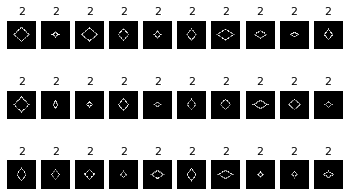

min =  0.0105794477


In [40]:
fn1 = 'dataTrain1.bin'
fn1_labels = 'labelsTrain1.bin'
n1 = 500
file = open(fn1, 'wb')
file2 = open(fn1_labels, 'wb')
one_class3(n1, file, file2)
file.close()
file2.close()

train_data, train_labels = load_data(fn1, fn1_labels)
train_img = train_data.reshape(n1, w, h)

ttl = 'ромб'
cls = 2
print("Train data")
plot_data(train_img, ttl, cls)
minsim = 0.0105794477#min_sim(train_img, n1)
sim1 = minsim*1.5
for i in range(train_img.shape[0]):
    img1 = train_img[i]
    for j in range (train_img.shape[0]):
        img2 = train_img[i]
        simi = 1 - compare_ssim(img1 , img2)
        if (simi>minsim and sim<sim1):
            print(simi)
            plt.subplot(1, 2, 1)
            plt.imshow(train_img[i], cmap = 'gray')
            plt.title(cls, fontsize = 11)
            plt.subplot(1, 2, 2)
            plt.imshow(train_img[j], cmap = 'gray')
            plt.title(cls, fontsize = 11)
            plt.axis('off')
            plt.subplots_adjust(hspace = -0.1)
            plt.show()
#smty = img_smty(train_img, minsim)
print("min = ", minsim)   

In [10]:
def one_class4(n, file, file2):
    #xs0 = border - w2 + 1
    dx = 0.1
    label = 3
    for i in range(n):
        angle = np.random.uniform(np.pi/3, 2*np.pi/3)
        x = 0
        r = np.random.uniform(10., 25.)
        arrPic = np.zeros((w, h), dtype = np.uint8)
        hr = r * np.cos(angle/2)
        task = 1

        if task == 1:
            side = np.random.randint(4)
        else:
            side = -1

        while x < r:
            x_noise = np.random.uniform(-0.5, 0.5)
            y_noise = np.random.uniform(-1, 1)

            x1 = x * np.sin(angle/2)
            y1 = hr - border - (x + x_noise) * np.cos(angle/2) + y_noise

            x2 = - x * np.sin(angle/2)
            y2 = -(hr - border - (x + x_noise) * np.cos(angle/2)) + y_noise

            ix1 = min(int(w2 + x1), w-1)
            ix2 = max(0, int(w2 + x2))

            iy1 = min(h-1, int((h2 - y1)))           
            iy2 = max(0, int((h2 - y2)))
            clr = np.random.randint(clr_mim, clr_max)

            if side == 0:
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix1] = clr
                arrPic[iy2, ix2] = clr 
            elif side == 1:
                arrPic[iy1, ix1] = clr
                arrPic[iy2, ix1] = clr
                arrPic[iy2, ix2] = clr
            elif side == 2:
                arrPic[iy1, ix1] = clr
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix2] = clr
            elif side == 3:
                arrPic[iy1, ix1] = clr
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix1] = clr
            else:
                arrPic[iy1, ix1] = clr
                arrPic[iy1, ix2] = clr
                arrPic[iy2, ix1] = clr
                arrPic[iy2, ix2] = clr
            x += dx
        file.write(arrPic)
        file2.write(np.uint8(label))
#
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class4(n_train, file, file2)
    file.close()
    file2.close()
    file = open(fn_test, 'wb')
    file2 = open(fn_test_labels, 'wb')
    one_class4(n_test, file, file2)
    file.close()
    file2.close()
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    test_data, test_labels = load_data(fn_test, fn_test_labels)
    test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train, w, h)
        
    ttl = 'ромб'
    cls = 0
    print("Train data")
    plotData(train_img, ttl, cls)
    minsim = min_sim(train_img, 100)
    smty = img_smty(train_img, minsim)
    print('Count of similar images = {}'.format(len(smty)), "    min = ", minsim)   

    print("Test data")
    plotData(test_img, ttl, cls)
   # minsim = min_sim(test_img, 100)
    smty = img_smty(test_img, minsim)
    print('Count of similar images = {}'.format(len(smty)),  "    min = ", minsim)    
    
   # minsim = min_sim_2(train_img, test_img, 100)
    smty = two_img_smty(train_img, test_img, minsim)
    print('Count of similar images between train and test datas = {}'.format(len(smty)), "    min = ", minsim)    

Поехали
Потрачено времени: 9.475


In [11]:
def hyp(x, a):
    x_noise = np.random.uniform(-0.05, 0.05)
    y_noise = np.random.uniform(-0.05, 0.05)
    y = a/(x + x_noise) + y_noise
    return y
def one_class5(n, file, file2):
    #xs0 = border - w2 + 1
    label = 4
    task = 0
    for i in range(n):
        y_sgn = -1

        sgn = np.random.randint(2)
        coef_noise = np.random.uniform(0.5, 5.0)

        coef = -coef_noise #if sgn == 1 else coef_noise

        arrPic = np.zeros((w, h), dtype = np.uint8)
        xe = w2 - 1
        dx = 0.01
        x = 0

        while x < xe:
            x += dx
            y1 = hyp(x/10, coef)
            y2 = hyp((-1)*x/10, coef)

            ix1 = min(int(w2 + x), w-1)
            ix2 = max(0, int(w2 - x))

            iy1 = min(h-1, int((h2 + y1)))
            iy1 = max(0, iy1)
            iy2 = max(0, int((h2 + y2)))
            iy2 = min(h-1, iy2)
            clr = np.random.randint(clr_mim, clr_max)

            if y_sgn == 1:
                if sgn == 1:
                    arrPic[iy1, ix1] = clr
                else:
                    arrPic[iy2, ix2] = clr
            elif y_sgn == 0:
                if sgn == 1:
                    arrPic[iy2, ix1] = clr
                else:
                    arrPic[iy1, ix2] = clr
            else:
                if sgn == 1:
                    arrPic[iy1, ix1] = clr
                    arrPic[iy2, ix2] = clr
                else:
                    arrPic[iy1, ix2] = clr
                    arrPic[iy2, ix1] = clr
        file.write(arrPic)
        file2.write(np.uint8(label))
#
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class5(n_train, file, file2)
    file.close()
    file2.close()
    file = open(fn_test, 'wb')
    file2 = open(fn_test_labels, 'wb')
    one_class5(n_test, file, file2)
    file.close()
    file2.close()
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    test_data, test_labels = load_data(fn_test, fn_test_labels)
    test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train, w, h)
        
    ttl = 'гипербола'
    cls = 0
    print("Train data")
    plotData(train_img, ttl, cls)
    minsim = min_sim(train_img, 100)
    smty = img_smty(train_img, minsim)
    print('Count of similar images = {}'.format(len(smty)), "    min = ", minsim)   

    print("Test data")
    plotData(test_img, ttl, cls)
  #  minsim = min_sim(test_img, 100)
    smty = img_smty(test_img, minsim)
    print('Count of similar images = {}'.format(len(smty)),  "    min = ", minsim)    
    
  #  minsim = min_sim_2(train_img, test_img, 100)
    smty = two_img_smty(train_img, test_img, minsim)
    print('Count of similar images between train and test datas = {}'.format(len(smty)), "    min = ", minsim) 

Поехали


KeyboardInterrupt: 

In [12]:
def one_class6(n, file, file2):
    #xs0 = border - w2 + 1
    label = 5
    task = 1
    for i in range(n):
        if task == 1:
            y_sgn = np.random.randint(2) #if comp == False else -1
        else:
            y_sgn = -1

        sgn = np.random.randint(2)
        coef_noise = np.random.uniform(0.5, 5.0)

        coef = -coef_noise #if sgn == 1 else coef_noise

        arrPic = np.zeros((w, h), dtype = np.uint8)
        xe = w2 - 1
        dx = 0.01
        x = 0

        while x < xe:
            x += dx
            y1 = hyp(x/10, coef)
            y2 = hyp((-1)*x/10, coef)

            ix1 = min(int(w2 + x), w-1)
            ix2 = max(0, int(w2 - x))

            iy1 = min(h-1, int((h2 + y1)))
            iy1 = max(0, iy1)
            iy2 = max(0, int((h2 + y2)))
            iy2 = min(h-1, iy2)
            clr = np.random.randint(clr_mim, clr_max)

            if y_sgn == 1:
                if sgn == 1:
                    arrPic[iy1, ix1] = clr
                else:
                    arrPic[iy2, ix2] = clr
            elif y_sgn == 0:
                if sgn == 1:
                    arrPic[iy2, ix1] = clr
                else:
                    arrPic[iy1, ix2] = clr
            else:
                if sgn == 1:
                    arrPic[iy1, ix1] = clr
                    arrPic[iy2, ix2] = clr
                else:
                    arrPic[iy1, ix2] = clr
                    arrPic[iy2, ix1] = clr
        file.write(arrPic)
        file2.write(np.uint8(label))
#
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class6(n_train, file, file2)
    file.close()
    file2.close()
    file = open(fn_test, 'wb')
    file2 = open(fn_test_labels, 'wb')
    one_class6(n_test, file, file2)
    file.close()
    file2.close()
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    test_data, test_labels = load_data(fn_test, fn_test_labels)
    test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train, w, h)
        
    ttl = 'гипербола'
    cls = 0
    print("Train data")
    plotData(train_img, ttl, cls)
    minsim = min_sim(train_img, 100)
    smty = img_smty(train_img, minsim)
    print('Count of similar images = {}'.format(len(smty)), "    min = ", minsim)   

    print("Test data")
    plotData(test_img, ttl, cls)
 #   minsim = min_sim(test_img, 100)
    smty = img_smty(test_img, minsim)
    print('Count of similar images = {}'.format(len(smty)),  "    min = ", minsim)    
    
 #   minsim = min_sim_2(train_img, test_img, 100)
    smty = two_img_smty(train_img, test_img, minsim)
    print('Count of similar images between train and test datas = {}'.format(len(smty)), "    min = ", minsim) 

Поехали
Потрачено времени: 105.727


In [54]:
def one_class(n, file, file2):
    one_class1(n, file, file2)
    one_class2(n, file, file2)
    one_class3(n, file, file2)
    one_class4(n, file, file2)
    one_class5(n, file, file2)
    one_class6(n, file, file2)
def rotate(ang, img_array): # Поворот на угол ang
    # Приводим данные к типу uint8
    img_array = np.array(img_array, dtype = 'uint8')
    # Формируем изображение по массиву img_array
    img = Image.fromarray(img_array, 'L')
    # Поворот изображения на угол ang против часовой стрелки
    img = img.rotate(ang)
    # Переводим изображение в массив
    ix = img.size[0]
    iy = img.size[1]
    img_array_rot = np.array(img.getdata(), dtype = 'uint8').reshape(iy, ix)
    return img_array_rot

Train data


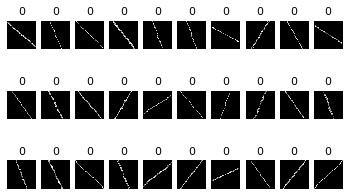

In [57]:
show = True
if not show:
    t0 = time.time()
    print('Поехали')
    file = open(fn_train, 'wb')
    file2 = open(fn_train_labels, 'wb')
    one_class(n_train, file, file2)
    file.close()
    file2.close()
    
    print('Потрачено времени:', round(time.time() - t0, 3))
else:
    #test_data, test_labels = load_data(fn_test, fn_test_labels)
    #test_img = test_data.reshape(n_test, w, h)
    
    train_data, train_labels = load_data(fn_train, fn_train_labels)
    train_img = train_data.reshape(n_train*6, w, h)
        
    ttl = 'все сразу'
    cls = 0
    minsim = 0.016
    print("Train data")
    plot_data(train_img, ttl, cls)
    

In [16]:
import numpy as np
import sys # Для sys.exit()
import matplotlib.pyplot as plt
import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

categorical = True
num_classes = 6 

In [17]:
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 2.15 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'acc', 'val_acc'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.001
    plt.plot(loss_acc, color = 'r', label = lb, linestyle = '--')
    plt.plot(val_loss_acc, color = 'g', label = lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    plt.ylim([0.95 * yMin, yMax])
    plt.legend()

(3600, 64, 64)
[0 0 0 ... 5 5 5]


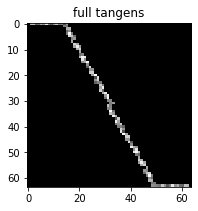

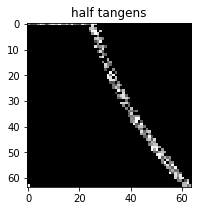

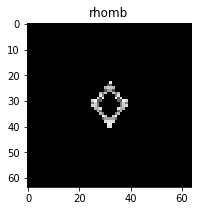

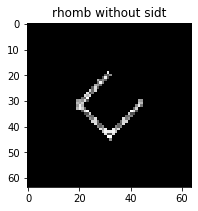

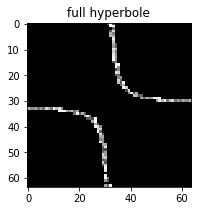

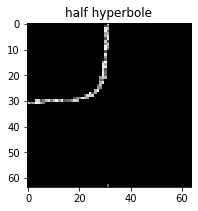

3600 обучающих образов
600 тестовых образов
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 4)         104       
_________________________________________________________________
flatten_6 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1048640   
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 390       
Total params: 1,049,134
Trainable params: 1,049,134
Non-trainable params: 0
_________________________________________________________________
Обучение
Epoch 1/20
360/360 - 9s - loss: 0.0153 - accuracy: 0.8747 - val_loss: 0.0235 - val_accuracy: 0.8717
Epoch 2/20
360/360 - 6s - loss: 0.0020 - accuracy: 0.9958 - val_loss: 0.0205 - val_accura

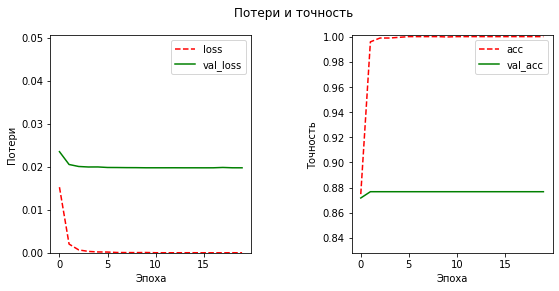

Тестирование
Время тестирования:  0.6220357418060303
Потери при тестировании:  0.019756896421313286
Точность при тестировании: 0.8766666650772095
Прогноз
Точность прогнозирования: 87.66666666666667%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

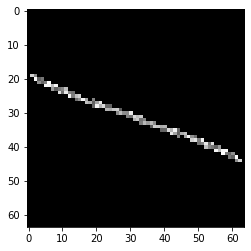

i = 1. Прогноз: 0. На самом деле: 4
i = 2. Прогноз: 0. На самом деле: 4
i = 3. Прогноз: 0. На самом деле: 4
i = 4. Прогноз: 0. На самом деле: 4
i = 5. Прогноз: 0. На самом деле: 4
i = 6. Прогноз: 0. На самом деле: 4
i = 7. Прогноз: 0. На самом деле: 4
i = 8. Прогноз: 0. На самом деле: 4
i = 9. Прогноз: 0. На самом деле: 4
i = 10. Прогноз: 0. На самом деле: 4
i = 11. Прогноз: 0. На самом деле: 4
i = 12. Прогноз: 0. На самом деле: 4
i = 13. Прогноз: 0. На самом деле: 4
i = 14. Прогноз: 0. На самом деле: 4
i = 15. Прогноз: 0. На самом деле: 4
i = 16. Прогноз: 0. На самом деле: 4
i = 17. Прогноз: 0. На самом деле: 4
i = 18. Прогноз: 0. На самом деле: 4
i = 19. Прогноз: 0. На самом деле: 4
i = 20. Прогноз: 0. На самом деле: 4
i = 21. Прогноз: 0. На самом деле: 4
i = 22. Прогноз: 0. На самом деле: 4
i = 23. Прогноз: 0. На самом деле: 4
i = 24. Прогноз: 0. На самом деле: 4
i = 25. Прогноз: 0. На самом деле: 4
i = 26. Прогноз: 0. На самом деле: 4
i = 27. Прогноз: 0. На самом деле: 4
i = 28. Пр

In [26]:
train_data, train_labels = load_data(fn_train, fn_train_labels)
test_data, test_labels = load_data(fn_test, fn_test_labels)
n_train = int(train_data.size / (w * h)) # Число рисунков для обучения
n_test = int(test_data.size / (w * h)) # Число тестовых рисунков
#
show = True # True or False
if show:
    def plotData(k, data, class_number, i):
        ttl = ''
        plt.figure(figsize=(10, 10))
        if class_number == 0:
            ttl = 'full tangens'
        elif class_number == 1:
            ttl = 'half tangens'
        elif class_number == 2:
            ttl = 'rhomb'
        elif class_number == 3:
            ttl = 'rhomb without sidt'
        elif class_number == 4:
            ttl = 'full hyperbole'
        elif class_number == 5:
            ttl = 'half hyperbole'
        plt.subplot(2, 3, k)
        plt.imshow(data[i], cmap = plt.get_cmap('gray'))
        plt.title(ttl)
#
    show_test = False # True or False
    if show_test:
        n = n_test
        data_show = test_data.reshape(n, w, h)
        labels = test_labels
    else:
        n = n_train
        data_show = train_data.reshape(n, w, h)
        print(data_show.shape)
        labels = train_labels
    def findClass(n, class_number):
        for i in range(n):
            if labels[i] == class_number:
                return i
    k = 0
    print(labels)
    for class_number in range(num_classes):
        i = findClass(n, class_number)
        k += 1
        #print('k=', k, 'i=', i)
        plotData(k, data_show, class_number, i)
    plt.subplots_adjust(hspace = 0.25) # wspace
    plt.show()
    #sys.exit()
#
train_data = train_data.reshape(n_train, w, h, 1)
test_data = test_data.reshape(n_test, w, h, 1)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data /= 255
test_data /= 255
test_labels_0 = test_labels # Для сравнения с результатами прогноза
if categorical:
    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)
#
print(train_data.shape[0], 'обучающих образов')
print(test_data.shape[0], 'тестовых образов')
#
model = Sequential()
model.add(Conv2D(4, kernel_size = (5, 5), strides = (1, 1), padding = 'same',
                 activation = 'relu', input_shape = (w, h, 1)))
#model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(loss = 'MSLE', optimizer = 'adamax', metrics = ['accuracy']) # loss = 'categorical_crossentropy' / mse
model.summary()
#
# Обучение
print('Обучение')
start_time = time.time()
history = model.fit(train_data, train_labels, batch_size = 10, epochs = 20, verbose = 2,
                    validation_data = (test_data, test_labels))
print('Время обучения: ', (time.time() - start_time))
#
history = history.history
plt.figure(figsize = (9, 4))
plt.subplots_adjust(wspace = 0.5)
one_plot(1, 'Потери', history['loss'], history['val_loss'])
one_plot(2, 'Точность', history['accuracy'], history['val_accuracy'])
plt.suptitle('Потери и точность')
plt.show()
print('Тестирование')
start_time = time.time()
score = model.evaluate(test_data, test_labels, verbose = 0)
print('Время тестирования: ', (time.time() - start_time))
#
print('Потери при тестировании: ', score[0])
print('Точность при тестировании:', score[1])
#
print("Прогноз")
classes = model.predict_classes(test_data) # , batch_size = 10
# np.sum(classes == test_labels_0) вернет сумму случаев, когда classes[i] = test_labels_0[i]
acc = np.sum(classes == test_labels_0) / n_test * 100
print("Точность прогнозирования: " + str(acc) + '%')
print(classes)
print("На самом деле:")
print(test_labels_0)
if acc < 100:
    show = True
    for i in range(n_test):
        if classes[i] != test_labels_0[i]:
            print('i = ' + str(i) + '. Прогноз: ' + str(classes[i]) + '. На самом деле: ' + str(test_labels_0[i]))
            if show:
                show = False
                plt.subplot()
                plt.imshow(test_data[i].reshape(w, h), cmap = plt.get_cmap('gray'))
                plt.show()

In [41]:
train_data, train_labels = load_data(fn_train, fn_train_labels)
test_data, test_labels = load_data(fn_test, fn_test_labels)
n_train = int(train_data.size / (w * h)) # Число рисунков для обучения
n_test = int(test_data.size / (w * h)) # Число тестовых рисунков
#
show = True # True or False
if show:
    def plotData(k, data, class_number, i):
        ttl = ''
        plt.figure(figsize=(10, 10))
        if class_number == 0:
            ttl = 'full tangens'
        elif class_number == 1:
            ttl = 'half tangens'
        elif class_number == 2:
            ttl = 'rhomb'
        elif class_number == 3:
            ttl = 'rhomb without sidt'
        elif class_number == 4:
            ttl = 'full hyperbole'
        elif class_number == 5:
            ttl = 'half hyperbole'
        plt.subplot(2, 3, k)
        plt.imshow(data[i], cmap = plt.get_cmap('gray'))
        plt.title(ttl)
#
    show_test = False # True or False
    if show_test:
        n = n_test
        data_show = test_data.reshape(n, w, h)
        labels = test_labels
    else:
        n = n_train
        data_show = train_data.reshape(n, w, h)
        print(data_show.shape)
        labels = train_labels
    def findClass(n, class_number):
        for i in range(n):
            if labels[i] == class_number:
                return i
    k = 0
    print(labels)
    class_number = 4
    while class_number == 4:#class_number in range(num_classes):
        i = findClass(n, class_number)
        k += 1
        #print('k=', k, 'i=', i)
        plotData(k, data_show, class_number, i)
        if k>10:
            break
    plt.subplots_adjust(hspace = 0.25) # wspace
    plt.show()
    sys.exit()
#
train_data = train_data.reshape(n_train, w, h, 1)
test_data = test_data.reshape(n_test, w, h, 1)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data /= 255
test_data /= 255
test_labels_0 = test_labels # Для сравнения с результатами прогноза
if categorical:
    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)
#
print(train_data.shape[0], 'обучающих образов')
print(test_data.shape[0], 'тестовых образов')
#
model = Sequential()
model.add(Conv2D(4, kernel_size = (5, 5), strides = (1, 1), padding = 'same',
                 activation = 'relu', input_shape = (w, h, 1)))
#model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
model.add(Conv2D(32, kernel_size = (5, 5), strides = (1, 1), padding = 'same',
activation = 'relu', input_shape = (w, h, 1)))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
model.add(Conv2D(32, kernel_size = (5, 5), strides = (1, 1), padding = 'same',
activation = 'relu', input_shape = (w, h, 1)))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))
#
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
# Обучение
print('Обучение')
start_time = time.time()
history = model.fit(train_data, train_labels, batch_size = 10, epochs = 5, verbose = 2,
                    validation_data = (test_data, test_labels))
print('Время обучения: ', (time.time() - start_time))
#
history = history.history
plt.figure(figsize = (9, 4))
plt.subplots_adjust(wspace = 0.5)
one_plot(1, 'Потери', history['loss'], history['val_loss'])
one_plot(2, 'Точность', history['accuracy'], history['val_accuracy'])
plt.suptitle('Потери и точность')
plt.show()
print('Тестирование')
start_time = time.time()
score = model.evaluate(test_data, test_labels, verbose = 0)
print('Время тестирования: ', (time.time() - start_time))
#
print('Потери при тестировании: ', score[0])
print('Точность при тестировании:', score[1])
#
print("Прогноз")
classes = model.predict_classes(test_data) # , batch_size = 10
# np.sum(classes == test_labels_0) вернет сумму случаев, когда classes[i] = test_labels_0[i]
acc = np.sum(classes == test_labels_0) / n_test * 100
print("Точность прогнозирования: " + str(acc) + '%')
print(classes)
print("На самом деле:")
print(test_labels_0)
if acc < 100:
    show = True
    for i in range(n_test):
        if classes[i] != test_labels_0[i]:
            print('i = ' + str(i) + '. Прогноз: ' + str(classes[i]) + '. На самом деле: ' + str(test_labels_0[i]))
            if show:
                show = False
                plt.subplot()
                plt.imshow(test_data[i].reshape(w, h), cmap = plt.get_cmap('gray'))
                plt.show()

SyntaxError: invalid syntax (<ipython-input-41-7a67ed0c457e>, line 43)